# Theme 3: Product Manufacturing / Mechanical Engineering

**Studio 1 – 6 / Group 3**  
  
**Name:** Jackson Webb (103572997)  
**Name:** Chathil Vithanage (104195065)  
**Name:** Maleesha Basnayake (104194813)  
**Name:** Nishen Pallawala (104346782)  

## Data Cleaning and Preparation

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import IsolationForest

In [3]:
# Load the three datasets
good_df = pd.read_csv("good.csv")
low_bad_df = pd.read_csv("low bad.csv")
high_bad_df = pd.read_csv("high bad.csv")

# Add a new column to identify the quality class
good_df['Quality'] = 'good'
low_bad_df['Quality'] = 'low_bad'
high_bad_df['Quality'] = 'high_bad'

# Combine all three into a single dataset
combined_df = pd.concat([good_df, low_bad_df, high_bad_df], ignore_index=True)

# Preview the combined dataset
print(combined_df.head())

        VYP batch         Part        Set Time  FFTE Feed solids SP  \
0  102_2019_07_02  Yeast - BRN  2/07/2019 0:10                 50.0   
1  102_2019_07_02  Yeast - BRN  2/07/2019 0:10                 50.0   
2  102_2019_07_02  Yeast - BRN  2/07/2019 0:10                 50.0   
3  102_2019_07_02  Yeast - BRN  2/07/2019 0:10                 50.0   
4  102_2019_07_02  Yeast - BRN  2/07/2019 0:10                 50.0   

   FFTE Production solids SP  FFTE Steam pressure SP  TFE Out flow SP  \
0                      41.09                  118.44          2186.05   
1                      41.09                  118.44          2186.05   
2                      41.09                  118.44          2186.05   
3                      41.09                  118.44          2186.05   
4                      41.09                  118.44          2186.05   

   TFE Production solids SP  TFE Vacuum pressure SP  TFE Steam pressure SP  \
0                      67.0                  -79.82     

In [4]:
# Clean column names
combined_df.columns = (
    combined_df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

# Convert Set Time to datetime
combined_df['set_time'] = pd.to_datetime(combined_df['set_time'], dayfirst=True)

In [5]:
# Preview all columns
print("All columns:\n", combined_df.columns.tolist())

# Create lists based on column naming patterns
sp_columns = [col for col in combined_df.columns if "_sp" in col]
pv_columns = [col for col in combined_df.columns if "_pv" in col]

# Metadata columns (manually listed)
meta_columns = ['vyp_batch', 'part', 'set_time', 'quality']

# Optional: Remaining system-specific or ungrouped columns
other_columns = list(set(combined_df.columns) - set(sp_columns) - set(pv_columns) - set(meta_columns))

# Print summaries
print(f"\nSet Point (SP) columns: {len(sp_columns)} →", sp_columns)
print(f"\nProcess Variable (PV) columns: {len(pv_columns)} →", pv_columns)
print(f"\nOther columns: {len(other_columns)} →", other_columns)

All columns:
 ['vyp_batch', 'part', 'set_time', 'ffte_feed_solids_sp', 'ffte_production_solids_sp', 'ffte_steam_pressure_sp', 'tfe_out_flow_sp', 'tfe_production_solids_sp', 'tfe_vacuum_pressure_sp', 'tfe_steam_pressure_sp', 'extract_tank_level', 'ffte_discharge_density', 'ffte_discharge_solids', 'ffte_feed_flow_rate_pv', 'ffte_feed_solids_pv', 'ffte_heat_temperature_1', 'ffte_heat_temperature_2', 'ffte_heat_temperature_3', 'ffte_production_solids_pv', 'ffte_steam_pressure_pv', 'tfe_input_flow_pv', 'tfe_level', 'tfe_motor_current', 'tfe_motor_speed', 'tfe_out_flow_pv', 'tfe_product_out_temperature', 'tfe_production_solids_pv', 'tfe_production_solids_density', 'tfe_steam_pressure_pv', 'tfe_steam_temperature', 'tfe_tank_level', 'tfe_temperature', 'tfe_vacuum_pressure_pv', 'quality']

Set Point (SP) columns: 8 → ['ffte_feed_solids_sp', 'ffte_production_solids_sp', 'ffte_steam_pressure_sp', 'tfe_out_flow_sp', 'tfe_production_solids_sp', 'tfe_vacuum_pressure_sp', 'tfe_steam_pressure_sp', 'tf

In [6]:
for col in sp_columns + pv_columns:
    combined_df[f"{col}_lag1"] = combined_df[col].shift(1)

In [7]:
for col in sp_columns + pv_columns:
    combined_df[f"{col}_roll3"] = combined_df[col].rolling(window=3).mean()

In [8]:
for col in sp_columns + pv_columns:
    combined_df[f"{col}_delta"] = combined_df[col].diff()

In [9]:
combined_df = pd.get_dummies(combined_df, columns=['part'])

In [10]:
combined_df.dropna(inplace=True)

In [11]:
combined_df.to_csv("combined_cleaned_features.csv", index=False)

In [12]:
# Rolling mean over 3 steps
for col in sp_columns + pv_columns:
    combined_df[f"{col}_roll3"] = combined_df[col].rolling(window=3).mean()

# Rate of change (delta)
for col in sp_columns + pv_columns:
    combined_df[f"{col}_delta"] = combined_df[col].diff()

In [13]:
# One-hot encode yeast type
#combined_df = pd.get_dummies(combined_df, columns=['part'])

# Drop nulls from lag/rolling/diff
combined_df.dropna(inplace=True)

## Model Training

### Dataset Splitting (70/30)

In [14]:
# Define features and labels
exclude = ['vyp_batch', 'set_time', 'quality']
X = combined_df.drop(columns=exclude)
y = combined_df['quality']

# 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

### RandomForestClassifier

In [33]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Performance Evaluation

In [34]:
from sklearn.metrics import classification_report, accuracy_score

# Predict and evaluate
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.973990342405619
              precision    recall  f1-score   support

        good       0.97      0.98      0.97      3990
    high_bad       0.98      0.98      0.98      4349
     low_bad       0.96      0.91      0.94       773

    accuracy                           0.97      9112
   macro avg       0.97      0.96      0.96      9112
weighted avg       0.97      0.97      0.97      9112

Confusion Matrix:
[[3901   64   25]
 [  77 4267    5]
 [  53   13  707]]


## SP Recommendation via Regression


In [16]:
# Filter only 'good' quality batches
df_good = combined_df[combined_df['quality'] == 'good'].copy()

# Select SP targets to predict
sp_targets = [
    'ffte_feed_solids_sp',
    'ffte_production_solids_sp',
    'tfe_production_solids_sp',
    'tfe_steam_pressure_sp'
]

# Define input features (exclude meta and targets)
exclude_cols = ['vyp_batch', 'set_time', 'quality'] + sp_targets
X = df_good.drop(columns=exclude_cols)
y = df_good[sp_targets]

In [17]:
# Wrap base regressor for multi-target prediction
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X, y) 

# Predict SPs
y_pred = model.predict(X)

# Evaluate performance for each SP target
for i, col in enumerate(y.columns):
    print(f"\n📍 {col}")
    print("MAE:", mean_absolute_error(y[col], y_pred[:, i]))
    mse = mean_squared_error(y[col], y_pred[:, i])
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)


📍 ffte_feed_solids_sp
MAE: 0.003064235223341878
RMSE: 0.06770407091326419

📍 ffte_production_solids_sp
MAE: 0.00124665363212656
RMSE: 0.017264871918907812

📍 tfe_production_solids_sp
MAE: 0.05355090239133742
RMSE: 0.26167651005185627

📍 tfe_steam_pressure_sp
MAE: 0.03754699954880431
RMSE: 0.6150874175332319


## Anomaly Detection

In [18]:
# Load the downtime dataset
downtime_df = pd.read_csv("downtime.csv")

# Create downtime timestamp
downtime_df['event_time'] = pd.to_datetime(
    downtime_df['Production Date'] + ' ' + downtime_df['Time'],
    dayfirst=True,
    errors='coerce'
)

# Keep only relevant columns for now
downtime_df = downtime_df[['event_time', 'Cause Category', 'Cause', 'Total Time Mins']]
downtime_df.dropna(subset=['event_time'], inplace=True)

# Preview
downtime_df.head()

,event_time,Cause Category,Cause,Total Time Mins
0,2020-05-04 13:30:00,TFE,Low Solids,30
1,2020-05-04 15:25:00,TFE,Low Solids,10
2,2020-05-04 15:45:00,TFE,Low Solids,10
3,2020-05-04 18:00:00,TFE,Low Solids,10
4,2020-05-04 20:10:00,TFE,Low Solids,15


In [21]:
# Load main cleaned dataset (if not already loaded)
combined_df = pd.read_csv("combined_cleaned_features.csv", parse_dates=['set_time'])

# Add a new anomaly label column, default = 0 (normal)
combined_df['anomaly'] = 0

# Define how close to a downtime event counts as "anomaly" (in minutes)
window_minutes = 15

# Loop through downtime events and flag nearby rows
for downtime_time in downtime_df['event_time']:
    mask = (
        (combined_df['set_time'] >= downtime_time - pd.Timedelta(minutes=window_minutes)) &
        (combined_df['set_time'] <= downtime_time + pd.Timedelta(minutes=window_minutes))
    )
    combined_df.loc[mask, 'anomaly'] = 1

# Preview result
combined_df['anomaly'].value_counts()

anomaly
0    29947
1      426
Name: count, dtype: int64

Train Anomaly Detection Model (Isolation Forest)

In [22]:
# Drop non-feature columns
exclude_cols = ['vyp_batch', 'set_time', 'quality', 'anomaly']
X_anomaly = combined_df.drop(columns=[col for col in exclude_cols if col in combined_df.columns])

# Labels (for evaluation only — not used in training)
y_anomaly = combined_df['anomaly']

In [23]:
# Train the model
iso_model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_model.fit(X_anomaly)

# Predict anomalies: -1 = anomaly, 1 = normal
y_pred_iso = iso_model.predict(X_anomaly)
y_pred_iso = [1 if val == -1 else 0 for val in y_pred_iso]  # convert to 1=anomaly, 0=normal

print(classification_report(y_anomaly, y_pred_iso))
print(confusion_matrix(y_anomaly, y_pred_iso))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     29947
           1       0.05      0.18      0.07       426

    accuracy                           0.94     30373
   macro avg       0.52      0.57      0.52     30373
weighted avg       0.97      0.94      0.95     30373

[[28369  1578]
 [  348    78]]


## Hyperparameter Tuning

### GridSearchCV

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_randomforest = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid=param_grid_randomforest,
    cv=5,
    n_jobs=-1,
    verbose=1 
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Estimator: RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=200)


### Performance Evaluation

In [35]:
from sklearn.metrics import classification_report, accuracy_score

# Predict and evaluate
hp_model = grid_search.best_estimator_
y_pred_hp = hp_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_hp))
print(classification_report(y_test, y_pred_hp))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_hp)
print(confusion_matrix(y_test, y_pred_hp))

Accuracy: 0.9817822651448639
              precision    recall  f1-score   support

        good       0.98      0.99      0.98      3990
    high_bad       0.99      0.99      0.99      4349
     low_bad       0.97      0.94      0.95       773

    accuracy                           0.98      9112
   macro avg       0.98      0.97      0.97      9112
weighted avg       0.98      0.98      0.98      9112

Confusion Matrix:
[[3931   38   21]
 [  52 4292    5]
 [  46    4  723]]


#### CM Visualisation

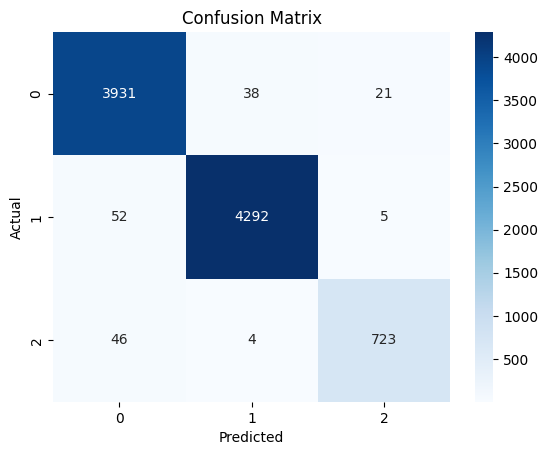

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
